In [119]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import os
from PIL import Image

In [112]:
dataset_path = 'Dataset(Agricultural-crops)'
# new_dataset = 'train'
img_width, img_height = 180, 180

find unsupported images

In [125]:
# List to store paths of images that are not in supported formats
unsupported_images = []

# Supported formats
supported_formats = ('jpeg', 'png', 'gif', 'bmp')

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            with Image.open(file_path) as img:
                if img.format.lower() not in supported_formats:
                    unsupported_images.append(file_path)
        except IOError:
            unsupported_images.append(file_path)

# Print unsupported images
if unsupported_images:
    print("Unsupported image formats found:")
    for img_path in unsupported_images:
        print(img_path)
else:
    print("All images are in supported formats.")

All images are in supported formats.


convert unsupported image into valid one

In [124]:
#convert those image into supported one

for img_path in unsupported_images:
    try:
        img = Image.open(img_path)
        # Convert to RGB if image has an alpha channel
        if img.mode in ("RGBA", "P"):
            img = img.convert("RGB")
        # Save the image in JPEG format
        img.save(img_path, format="JPEG")
    except Exception as e:
        print(f"Failed to convert {img_path}: {e}")

take input

In [126]:
train_data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=32,
    validation_split=False,
)

Found 829 files belonging to 30 classes.


In [127]:
data_categories = train_data.class_names
print(data_categories)

['Cherry', 'Coffee-plant', 'Cucumber', 'Fox_nut(Makhana)', 'Lemon', 'Olive-tree', 'Pearl_millet(bajra)', 'Tobacco-plant', 'almond', 'banana', 'cardamom', 'chilli', 'clove', 'coconut', 'cotton', 'gram', 'jowar', 'jute', 'maize', 'mustard-oil', 'papaya', 'pineapple', 'rice', 'soyabean', 'sugarcane', 'sunflower', 'tea', 'tomato', 'vigna-radiati(Mung)', 'wheat']


randomly ploting some image

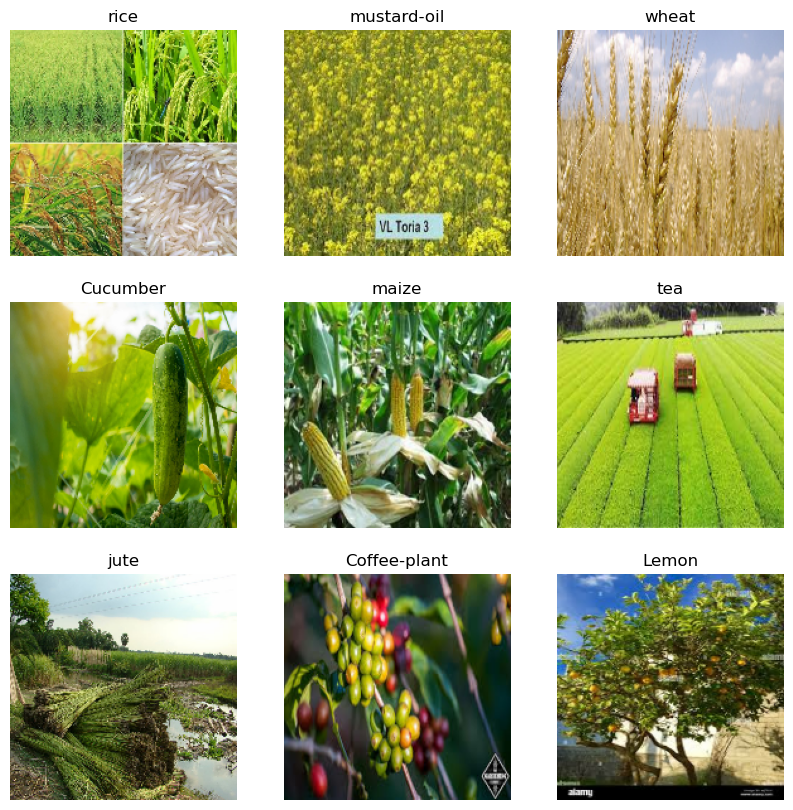

In [130]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(data_categories[labels[i]])
        plt.axis('off')

defining CNN layers

In [131]:
model = tf.keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128),
    layers.Dense(len(data_categories))
])

In [132]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [134]:
epochs = 5
history = model.fit(train_data, epochs=epochs)

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.8467 - loss: 0.6023
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.9378 - loss: 0.2535
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.9639 - loss: 0.1480
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.9780 - loss: 0.1084
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.9885 - loss: 0.0496


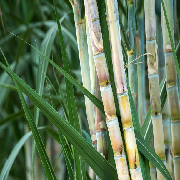

In [139]:
images = 'sugarcane.jpg'
images = tf.keras.utils.load_img(images, target_size=(img_width, img_height))
img_arr = tf.keras.utils.img_to_array(images)
img_bat = tf.expand_dims(img_arr, axis=0)
images

In [140]:
predictions = model.predict(img_bat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [141]:
score = tf.nn.softmax(predictions)
score

<tf.Tensor: shape=(1, 30), dtype=float32, numpy=
array([[6.6562011e-06, 2.1957474e-07, 7.5019976e-08, 5.2265797e-08,
        2.6569558e-07, 7.0696042e-05, 9.8403854e-09, 3.3203968e-09,
        2.0073438e-03, 7.4845821e-06, 6.1107592e-08, 3.1843072e-06,
        2.8377242e-06, 1.0481029e-08, 2.7505143e-07, 6.9150232e-09,
        1.2877652e-07, 9.6250741e-09, 1.1594712e-09, 4.8741849e-10,
        1.7841005e-07, 6.0256986e-09, 7.5863468e-08, 3.5583244e-07,
        9.9788731e-01, 7.6053986e-08, 5.6091978e-11, 1.2153635e-05,
        5.1933773e-07, 5.0161549e-11]], dtype=float32)>

In [142]:
print('Veg/Fruit in image is {} with accuracy of {:0.2f}'.format(data_categories[np.argmax(score)], np.max(score)*100))

Veg/Fruit in image is sugarcane with accuracy of 99.79


In [143]:
model.save('veg_image.keras')